# Project: Wrangling and Analyze Data

## Data Gathering
In the cell below, gather **all** three pieces of data for this project and load them in the notebook. **Note:** the methods required to gather each data are different.
1. Directly download the WeRateDogs Twitter archive data (twitter_archive_enhanced.csv)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sns

%matplotlib inline

In [4]:
df_csv = pd.read_csv('twitter-archive-enhanced.csv')
df_csv.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


2. Use the Requests library to download the tweet image prediction (image_predictions.tsv)

In [3]:
import requests
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)
with open(url.split('/')[-1], 'wb') as file:
        file.write(r.content)


In [5]:
df_tsv = pd.read_csv('image-predictions.tsv', sep= '\t')
df_tsv.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


3. Use the Tweepy library to query additional data via the Twitter API (tweet_json.txt)

In [5]:
import tweepy

#Defining the keys
consumer_key = '***'
consumer_secret = '****'
access_token = '****'
access_secret = '****'
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [6]:


api = tweepy.API(auth,wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

# Fetch tweets from the twitter API using the following loop:
tweets = []
# Tweets that can't be found are saved in the list below:
no_tweets = []

for tweet_id in df_csv['tweet_id']:   
    try:
        tweets.append(api.get_status(tweet_id))
    except Exception as e:
        no_tweets.append(tweet_id)
        

Rate limit reached. Sleeping for: 733
Rate limit reached. Sleeping for: 733


In [7]:
print(len(tweets))
print(len(no_tweets))

2328
28


In [8]:
#Isolating the json part of each tweepy status object that we have downloaded and adding them all into a list
import json

dict_list = []
for each_json_tweet in tweets:
    dict_list.append(each_json_tweet._json)
    
#We write this list into a txt file
with open('tweet_json.txt', 'w') as file:
        file.write(json.dumps(dict_list, indent=4))

In [9]:
#identify information of interest from JSON dictionaries in txt file
#and put it in a dataframe called tweet JSON
my_list = []
with open('tweet_json.txt', encoding='utf-8') as file:  
    all_data = json.load(file)
    for each_dictionary in all_data:
        tweet_id = each_dictionary['id']
        whole_tweet = each_dictionary['text']
        only_url = whole_tweet[whole_tweet.find('https'):]
        favorite_count = each_dictionary['favorite_count']
        retweet_count = each_dictionary['retweet_count']
        followers_count = each_dictionary['user']['followers_count']
        friends_count = each_dictionary['user']['friends_count']
        whole_source = each_dictionary['source']
        only_device = whole_source[whole_source.find('rel="nofollow">') + 15:-4]
        source = only_device
        retweeted_status = each_dictionary['retweeted_status'] = each_dictionary.get('retweeted_status', 'Original tweet')
        if retweeted_status == 'Original tweet':
            url = only_url
        else:
            retweeted_status = 'This is a retweet'
            url = 'This is a retweet'

        my_list.append({'tweet_id': str(tweet_id),
                             'favorite_count': int(favorite_count),
                             'retweet_count': int(retweet_count),
                             'followers_count': int(followers_count),
                             'friends_count': int(friends_count),
                             'url': url,
                             'source': source,
                             'retweeted_status': retweeted_status,
                            })
        df_json = pd.DataFrame(my_list)

In [10]:
df_json.head(2)

,favorite_count,followers_count,friends_count,retweet_count,retweeted_status,source,tweet_id,url
0,34481,9053461,20,7174,Original tweet,Twitter for iPhone,892420643555336193,https://t.co/MgUWQ76dJU
1,29909,9053461,20,5391,Original tweet,Twitter for iPhone,892177421306343426,https://t.co/aQFSeaCu9L


## Assessing Data
In this section, detect and document at least **eight (8) quality issues and two (2) tidiness issue**. You must use **both** visual assessment
programmatic assessement to assess the data.

**Note:** pay attention to the following key points when you access the data.

* You only want original ratings (no retweets) that have images. Though there are 5000+ tweets in the dataset, not all are dog ratings and some are retweets.
* Assessing and cleaning the entire dataset completely would require a lot of time, and is not necessary to practice and demonstrate your skills in data wrangling. Therefore, the requirements of this project are only to assess and clean at least 8 quality issues and at least 2 tidiness issues in this dataset.
* The fact that the rating numerators are greater than the denominators does not need to be cleaned. This [unique rating system](http://knowyourmeme.com/memes/theyre-good-dogs-brent) is a big part of the popularity of WeRateDogs.
* You do not need to gather the tweets beyond August 1st, 2017. You can, but note that you won't be able to gather the image predictions for these tweets since you don't have access to the algorithm used.



In [11]:
df_csv.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [12]:
df_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [13]:
df_csv.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
df_csv.isnull().sum()

tweet_id                         0
in_reply_to_status_id         2278
in_reply_to_user_id           2278
timestamp                        0
source                           0
text                             0
retweeted_status_id           2175
retweeted_status_user_id      2175
retweeted_status_timestamp    2175
expanded_urls                   59
rating_numerator                 0
rating_denominator               0
name                             0
doggo                            0
floofer                          0
pupper                           0
puppo                            0
dtype: int64

In [15]:
df_csv.duplicated().value_counts()

False    2356
dtype: int64

In [16]:
df_csv.nunique()

tweet_id                      2356
in_reply_to_status_id           77
in_reply_to_user_id             31
timestamp                     2356
source                           4
text                          2356
retweeted_status_id            181
retweeted_status_user_id        25
retweeted_status_timestamp     181
expanded_urls                 2218
rating_numerator                40
rating_denominator              18
name                           957
doggo                            2
floofer                          2
pupper                           2
puppo                            2
dtype: int64

In [17]:
df_csv.rating_numerator.value_counts(sort=False)

0         2
2         9
4        17
6        32
8       102
10      461
12      558
14       54
20        1
24        1
26        1
44        1
50        1
60        1
80        1
84        1
88        1
144       1
182       1
204       1
420       2
666       1
960       1
1776      1
1         9
3        19
5        37
7        55
9       158
11      464
13      351
15        2
17        1
27        1
45        1
75        2
99        1
121       1
143       1
165       1
Name: rating_numerator, dtype: int64

In [18]:
df_csv.rating_denominator.value_counts(sort=False)

0         1
2         1
10     2333
16        1
20        2
40        1
50        3
70        1
80        2
90        1
110       1
120       1
130       1
150       1
170       1
7         1
11        3
15        1
Name: rating_denominator, dtype: int64

In [19]:
a4 = df_csv['doggo'].value_counts()
a3 = df_csv['pupper'].value_counts()
a2 = df_csv['puppo'].value_counts()
a1 = df_csv['floofer'].value_counts()
print (a1,a2,a3,a4)

None       2346
floofer      10
Name: floofer, dtype: int64 None     2326
puppo      30
Name: puppo, dtype: int64 None      2099
pupper     257
Name: pupper, dtype: int64 None     2259
doggo      97
Name: doggo, dtype: int64


In [20]:
df_tsv.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [21]:
df_tsv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [22]:
df_tsv.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


In [23]:
df_tsv.isnull().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [24]:
df_tsv.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

In [25]:
df_tsv.duplicated().value_counts()

False    2075
dtype: int64

In [26]:
df_tsv.jpg_url.duplicated().sum()

66

In [27]:
df_json.head()

,favorite_count,followers_count,friends_count,retweet_count,retweeted_status,source,tweet_id,url
0,34481,9053461,20,7174,Original tweet,Twitter for iPhone,892420643555336193,https://t.co/MgUWQ76dJU
1,29909,9053461,20,5391,Original tweet,Twitter for iPhone,892177421306343426,https://t.co/aQFSeaCu9L
2,22505,9053461,20,3553,Original tweet,Twitter for iPhone,891815181378084864,https://t.co/r0YlrsGCgy
3,37724,9053461,20,7398,Original tweet,Twitter for iPhone,891689557279858688,https://t.co/tD36da7qLQ
4,36015,9053461,20,7933,Original tweet,Twitter for iPhone,891327558926688256,https://t.co/0g0KMIVXZ3


In [28]:
df_json.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 8 columns):
favorite_count      2328 non-null int64
followers_count     2328 non-null int64
friends_count       2328 non-null int64
retweet_count       2328 non-null int64
retweeted_status    2328 non-null object
source              2328 non-null object
tweet_id            2328 non-null object
url                 2328 non-null object
dtypes: int64(4), object(4)
memory usage: 145.6+ KB


In [29]:
df_json.describe()

,favorite_count,followers_count,friends_count,retweet_count
count,2328.000000,2.328000e+03,2328.0,2328.000000
mean,7200.318729,9.053482e+06,20.0,2531.574313
std,11185.535271,4.927904e+01,0.0,4286.384602
min,0.000000,9.053461e+06,20.0,1.000000
25%,1250.750000,9.053463e+06,20.0,510.750000
50%,3116.000000,9.053467e+06,20.0,1178.500000
75%,8794.000000,9.053473e+06,20.0,2926.500000
max,147920.000000,9.053953e+06,20.0,72569.000000


In [30]:
df_json.duplicated().value_counts()

False    2328
dtype: int64

In [31]:
df_json.retweeted_status.value_counts()

Original tweet       2167
This is a retweet     161
Name: retweeted_status, dtype: int64

### Quality issues
1. Timestamp should be in datetime format (csv_df)

2. Drop columns with too many missing values (df_csv)

3. Change tweet_id to type str in order to merge with the other 2 tables


4.  Keep original ratings (no retweets) that have images (df_csv)

5. Errors in name column ( a, an,... ) in df_csv

6. Keep original tweets  (df_json file) 

7. drop columns (df_tsv)

8.  Drop  jpg_url duplicated (df_tsv)

### Tidiness issues
1. Melt the doggo, floofer, pupper and puppo columns (df_csv)

2. merge all the dataframes in one Dataset

## Cleaning Data
In this section, clean **all** of the issues you documented while assessing. 

**Note:** Make a copy of the original data before cleaning. Cleaning includes merging individual pieces of data according to the rules of [tidy data](https://cran.r-project.org/web/packages/tidyr/vignettes/tidy-data.html). The result should be a high-quality and tidy master pandas DataFrame (or DataFrames, if appropriate).

In [28]:
# Make copies of original pieces of data
df_csv2 = df_csv.copy()
df_tsv2 = df_tsv.copy()
df_json2 = df_json.copy()

### Quality issues:

**1 Timestamp should be in datetime format**

**Define**: convert timestamp to DateTime format

**Code:**

In [29]:
#Change timestamp format

df_csv2['timestamp'] = pd.to_datetime(df_csv2['timestamp'])



**Test:**

In [30]:
df_csv2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null datetime64[ns]
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: datetime64[ns](1

**2 Drop columns with too many missing values (df_csv)**




**Define:** A lot of columns have missing values








**Code:**

In [31]:
df_csv2.drop(['in_reply_to_status_id', 'in_reply_to_user_id' ,
           'retweeted_status_timestamp'], axis=1, inplace=True)
 


**Test:**

In [32]:
list(df_csv2)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

**Tidiness issue:**




**1 Melt the doggo, floofer, pupper and puppo columns**



**Define:** There are four columns to define only the dog stage






**Code:**

In [33]:
#Create a column with all the values from doggo, floofer, pupper, puppo

df_csv2['all_dogs'] = df_csv2.doggo + df_csv2.floofer + df_csv2.pupper + df_csv2.puppo

In [34]:
#Check the values

df_csv2['all_dogs'].value_counts()

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: all_dogs, dtype: int64

In [35]:
#Create a function to obtain only one value 

def clean(df_csv2):
    if df_csv2['all_dogs'].count('None') == 2:
        return 'multiple types' #this means it has more than one dog type
    else:
        if df_csv2['all_dogs'].count('doggo') == 1:
            return 'doggo'
        elif df_csv2['all_dogs'].count('floofer') == 1:
            return 'floofer'
        elif df_csv2['all_dogs'].count('pupper') == 1:
            return 'pupper'
        elif df_csv2['all_dogs'].count('puppo') == 1:
            return 'puppo'
        else:
            return 'None'

df_csv2['dog_type'] = df_csv2.apply(clean, axis=1)

In [36]:

df_csv2['dog_type'].value_counts()

None              1976
pupper             245
doggo               83
puppo               29
multiple types      14
floofer              9
Name: dog_type, dtype: int64

In [37]:
list(df_csv2)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo',
 'all_dogs',
 'dog_type']

In [38]:
#Drop puppo, doggo ,floofer , pupper and all_dogs columns

df_csv2.drop(['doggo', 'floofer', 'pupper', 'puppo', 'all_dogs',], axis=1, inplace = True)

**Test:**

In [39]:
list(df_csv2)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'dog_type']

**4  Keep original ratings (no retweets) that have images**

**Define:** For the analysis we need only the ratings with images




**Code:**

In [40]:
#keep original ratings

df_csv2 = df_csv2[pd.isnull(df_csv2['retweeted_status_user_id'])]

**Test:**

In [41]:
#test
print(df_csv2.retweeted_status_user_id.value_counts().sum())

0


**5. Correct  errors in name column**

**Define:** There are some incorrect names in the name column ( a, an,... ) in df_csv







**Code:**

In [42]:
#Delete all incorrect names (a, an, ...)

df_csv2['name'][df_csv2['name'].str.match('[a-z]+')] = 'None'


**Test:**

In [43]:
df_csv2['name'].value_counts()

None        784
Lucy         11
Charlie      11
Cooper       10
Oliver       10
Tucker        9
Penny         9
Sadie         8
Lola          8
Winston       8
Daisy         7
Toby          7
Koda          6
Bailey        6
Stanley       6
Jax           6
Bo            6
Bella         6
Oscar         6
Rusty         5
Milo          5
Louis         5
Buddy         5
Bentley       5
Scout         5
Leo           5
Dave          5
Chester       5
Brody         4
Clarence      4
           ... 
Cuddles       1
Steve         1
Tove          1
Sweet         1
Nico          1
Rey           1
Ken           1
Brownie       1
Tupawc        1
Timofy        1
Barry         1
Roscoe        1
Maya          1
Chubbs        1
Cali          1
Obie          1
Sailor        1
Meyer         1
Rudy          1
Sky           1
Jiminus       1
Mac           1
Stefan        1
Vinnie        1
Heinrich      1
Reagan        1
Philbert      1
Brat          1
Glenn         1
Mattie        1
Name: name, Length: 931,

**6  Keep original tweets only**


**Define:** For the analysis we need only the original tweets




**Code:**

In [177]:
#Keep original tweets only

df_json2 = df_json2[df_json2['retweeted_status'] == 'Original tweet']

#TEST

df_json2['retweeted_status'].value_counts()

Original tweet    2167
Name: retweeted_status, dtype: int64

**7 Drop columns not needed for analysis (df_tsv)**




**Define:** drop columns that we don't need for the analysis




**Code:**

In [45]:
#Drop useless columns

df_tsv2.drop(['img_num', 'p1', 'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'], axis = 1, inplace = True)

**Test:**

In [46]:
list(df_tsv2)

['tweet_id', 'jpg_url']

**8 Drop jpg_url duplicated**



**Define:** For the analysis we don't need duplicated images



**Code**

In [47]:
df_tsv2 = df_tsv2.drop_duplicates(['jpg_url'], keep = 'last')

**Test:**

In [48]:
df_tsv2['jpg_url'].duplicated().value_counts()

False    2009
Name: jpg_url, dtype: int64

**4 Change tweet_id to type str in order to merge with the other 2 tables**


**Define:** In order to create one dataset that contains the 3 dataframes we need to change the type of tweet_id to make a join



**Code:**

In [180]:
df_json2['tweet_id'] = df_json2['tweet_id'].astype(int)

#TEST

df_json2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2167 entries, 0 to 2327
Data columns (total 8 columns):
favorite_count      2167 non-null int64
followers_count     2167 non-null int64
friends_count       2167 non-null int64
retweet_count       2167 non-null int64
retweeted_status    2167 non-null object
source              2167 non-null object
tweet_id            2167 non-null int64
url                 2167 non-null object
dtypes: int64(5), object(3)
memory usage: 152.4+ KB


**Tidiness issue**




**2 Merge all the dataframes in one Dataset**

**Define:** Condense the dataframes in one Dataset




**Code:**

In [181]:
DF1 = pd.merge(df_csv2, df_tsv2, how = 'left', on = ['tweet_id'])

#TEST

DF1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2174
Data columns (total 12 columns):
tweet_id                    2175 non-null int64
timestamp                   2175 non-null datetime64[ns]
source                      2175 non-null object
text                        2175 non-null object
retweeted_status_id         0 non-null float64
retweeted_status_user_id    0 non-null float64
expanded_urls               2117 non-null object
rating_numerator            2175 non-null int64
rating_denominator          2175 non-null int64
name                        2175 non-null object
dog_type                    2175 non-null object
jpg_url                     1928 non-null object
dtypes: datetime64[ns](1), float64(2), int64(3), object(6)
memory usage: 220.9+ KB


In [182]:
#drop columns with no values

DF1.drop(['retweeted_status_id', 'retweeted_status_user_id'], axis = 1, inplace = True )

In [183]:
DF1 = DF1[DF1['jpg_url'].notnull()]
DF1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1928 entries, 0 to 2174
Data columns (total 10 columns):
tweet_id              1928 non-null int64
timestamp             1928 non-null datetime64[ns]
source                1928 non-null object
text                  1928 non-null object
expanded_urls         1928 non-null object
rating_numerator      1928 non-null int64
rating_denominator    1928 non-null int64
name                  1928 non-null object
dog_type              1928 non-null object
jpg_url               1928 non-null object
dtypes: datetime64[ns](1), int64(3), object(6)
memory usage: 165.7+ KB


In [ ]:
DF = pd.merge(DF1, df_json2, how = 'left', on = ['tweet_id'])

**Test:**

In [51]:
DF.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1928 entries, 0 to 1927
Data columns (total 17 columns):
tweet_id              1928 non-null int64
timestamp             1928 non-null object
source_x              1928 non-null object
text                  1928 non-null object
expanded_urls         1928 non-null object
rating_numerator      1928 non-null int64
rating_denominator    1928 non-null int64
name                  1928 non-null object
dog_type              1928 non-null object
jpg_url               1928 non-null object
favorite_count        1921 non-null float64
followers_count       1921 non-null float64
friends_count         1921 non-null float64
retweet_count         1921 non-null float64
retweeted_status      1921 non-null object
source_y              1921 non-null object
url                   1921 non-null object
dtypes: float64(4), int64(3), object(10)
memory usage: 256.1+ KB


## Storing Data
Save gathered, assessed, and cleaned master dataset to a CSV file named "twitter_archive_master.csv".

In [185]:
DF.to_csv('twitter_archive_master.csv', encoding = 'utf-8')

## Analyzing and Visualizing Data
In this section, analyze and visualize your wrangled data. You must produce at least **three (3) insights and one (1) visualization.**

In [49]:
DF = pd.read_csv('twitter_archive_master.csv')

In [50]:
#Drop Unnamed column that was a duplicate

DF = DF.loc[:, ~DF.columns.str.contains('Unnamed')]
DF.head()

,tweet_id,timestamp,source_x,text,expanded_urls,rating_numerator,rating_denominator,name,dog_type,jpg_url,favorite_count,followers_count,friends_count,retweet_count,retweeted_status,source_y,url
0,892420643555336193,2017-08-01 16:23:56,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,34481.0,9053461.0,20.0,7174.0,Original tweet,Twitter for iPhone,https://t.co/MgUWQ76dJU
1,892177421306343426,2017-08-01 00:17:27,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,29909.0,9053461.0,20.0,5391.0,Original tweet,Twitter for iPhone,https://t.co/aQFSeaCu9L
2,891815181378084864,2017-07-31 00:18:03,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,22505.0,9053461.0,20.0,3553.0,Original tweet,Twitter for iPhone,https://t.co/r0YlrsGCgy
3,891689557279858688,2017-07-30 15:58:51,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,37724.0,9053461.0,20.0,7398.0,Original tweet,Twitter for iPhone,https://t.co/tD36da7qLQ
4,891327558926688256,2017-07-29 16:00:24,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,36015.0,9053461.0,20.0,7933.0,Original tweet,Twitter for iPhone,https://t.co/0g0KMIVXZ3


### Insight 1.1:  Favourites  over time

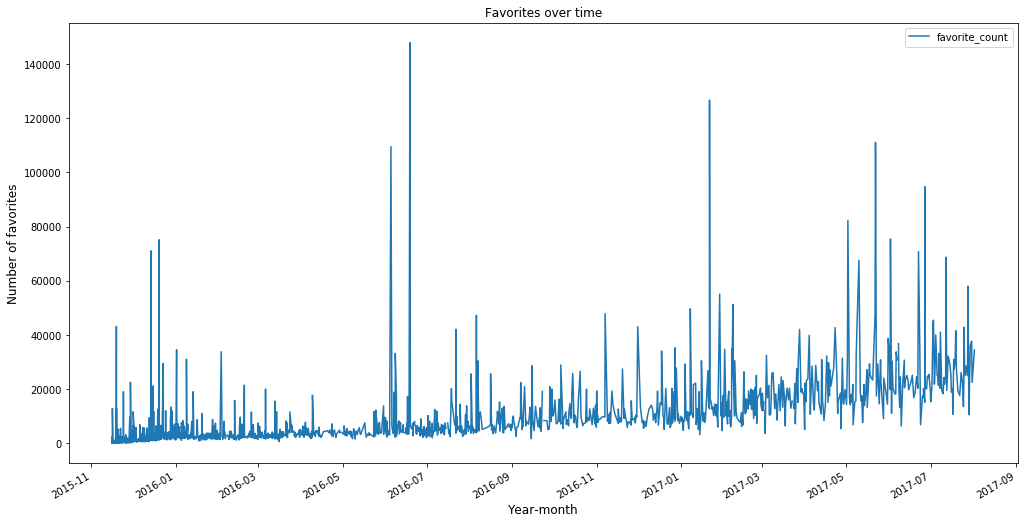

In [243]:
#Making a bar plot
DF.plot(x='timestamp', y='favorite_count', kind='line', figsize = (17,9), title = 'Favorites over time', fontsize = 10); 

plt.xlabel('Year-month',  fontsize = 12)
plt.ylabel('Number of favorites', fontsize = 12);


### Insight 1.2:  Retweets  over time

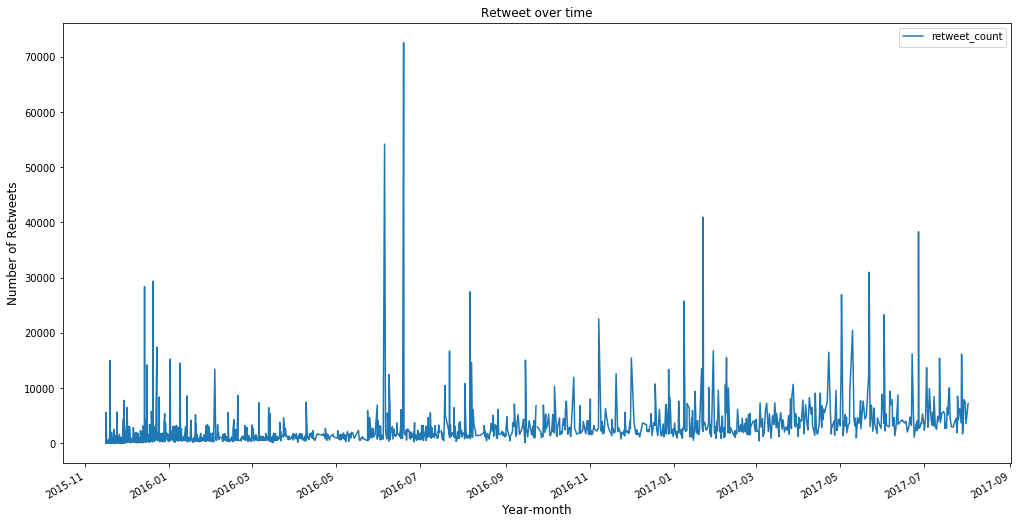

In [251]:
DF.plot(x='timestamp', y='retweet_count', kind='line', figsize = (17,9), title = 'Retweet over time', fontsize = 10); 

plt.xlabel('Year-month',  fontsize = 12)
plt.ylabel('Number of Retweets', fontsize = 12);


### Insight 1.3:  Correlation between favorites and retweets

Correlation between favorites  and Retweets is :  0.923559228504


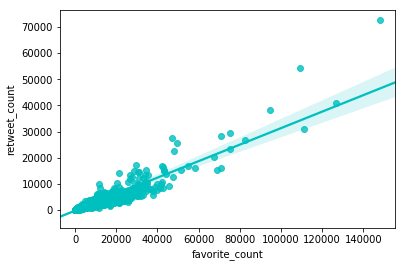

In [14]:
sns.regplot(x=DF['favorite_count'], y = DF['retweet_count'], color='c');
runtime_corr = DF.corr()

print("Correlation between favorites  and Retweets is : ",runtime_corr.loc['favorite_count','retweet_count'])


**Results:** there is a strong correlation between favorites and retweets (which was expected).

### Insight 2: Most common source 

In [17]:
source = DF.source_y.value_counts()
source


Twitter for iPhone    1885
Twitter Web Client      26
TweetDeck               10
Name: source_y, dtype: int64

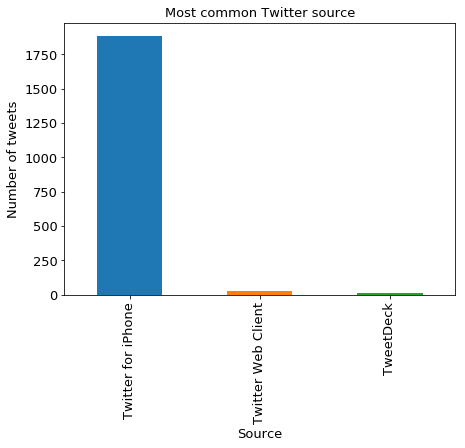

In [18]:
#Making a bar plot

source_plot = source.plot.bar(fontsize = 13)


source_plot.figure.set_size_inches(7, 5);

#Add labels
plt.title('Most common Twitter source', color = 'black', fontsize = '13')
plt.xlabel('Source', color = 'black', fontsize = '13')
plt.ylabel('Number of tweets', color = 'black', fontsize = '13');

**Results:** The most common source for twitter is iPhone.

### Insight 3:  most common Dog name

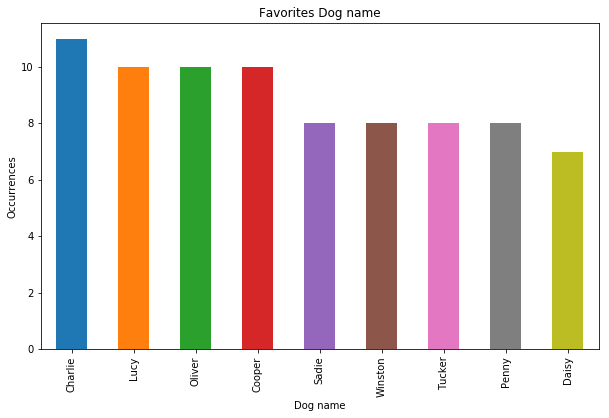

In [281]:
dog_name = DF.name.value_counts()[1:10]
#making a bar plot
dognames_plot = dog_name.plot( kind='bar', figsize = (10, 6), title = 'Favorites Dog name', fontsize = 10);
plt.xlabel('Dog name')
plt.ylabel('Occurrences');

**Results:** The most common name is Charlie (11) followed by Lucy, Oliver and Cooper (10).

### Insight 4:  Correlation heat map

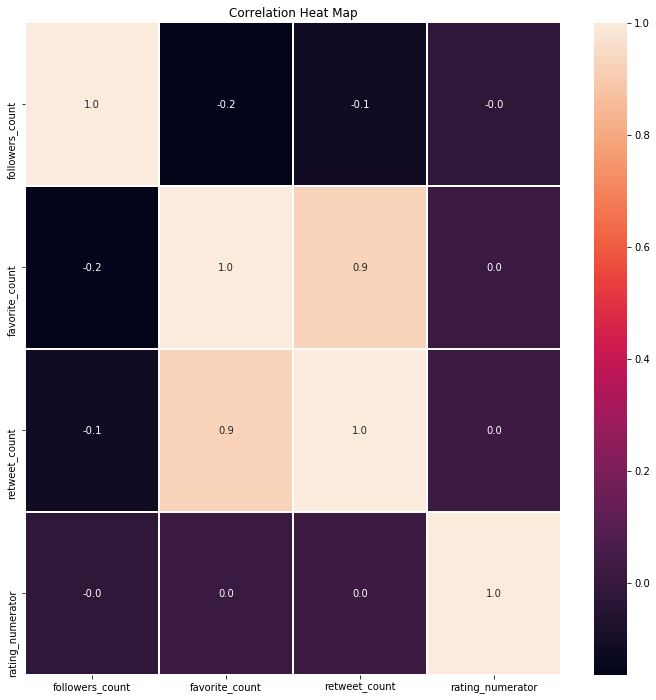

In [13]:
#make a heatmap plot

f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(DF[['source_y','followers_count','favorite_count','retweet_count',
               'rating_numerator']].corr(), annot=True, linewidths=.8, fmt= '.1f',ax=ax)
plt.title('Correlation Heat Map');

**Results:** This plot shows a strong correlation between followers and retweets (which was expected), and a negative correlation between both followers and favorites and followers and retweets ( which wasn't expected).